Error: No quedan datos después de aplicar el filtro de atípicos.
Usando todos los datos originales en lugar de filtrar atípicos.
Silhouette Score: 0.560


C:\Users\monts\AppData\Local\Temp\ipykernel_8048\3070251591.py:95: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("viridis", k)  # Gradiente de colores


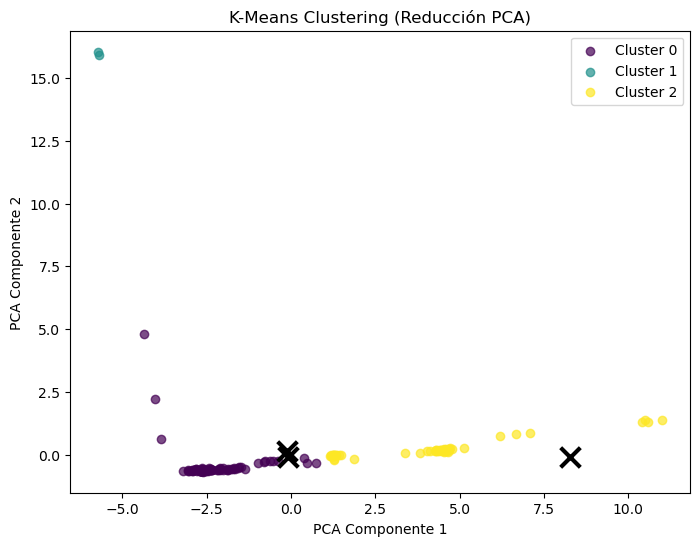

In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import numpy as np
import math
import matplotlib.pyplot as plt

# Cargar el dataset
df = pd.read_excel("C:/Users/monts/OneDrive/Escritorio/UAA/Inteligencia Artificial/VIH/dataset_VIH.xlsx")

# Manejo de valores nulos
df.fillna(0, inplace=True)

# Selección de características (excluir columnas irrelevantes)
features = df.drop(columns=["aminoacido", "clase", "sumatoria"]).columns
data = df[features].values

# Normalización de los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Filtrar datos atípicos: eliminar valores fuera de 3 desviaciones estándar
mean = np.mean(data_scaled, axis=0)
std_dev = np.std(data_scaled, axis=0)
filtered_data = data_scaled[np.all(np.abs(data_scaled - mean) < 3 * std_dev, axis=1)]

# Verificar si el filtrado eliminó todos los puntos
if filtered_data.shape[0] == 0:
    print("Error: No quedan datos después de aplicar el filtro de atípicos.")
    # Relajar aún más el filtro (usar todo el dataset)
    filtered_data = data_scaled
    print("Usando todos los datos originales en lugar de filtrar atípicos.")

# Funciones para K-Means
def initialize_centroids(data, k):
    centroids = data.copy()
    np.random.shuffle(centroids)
    return centroids[:k]

def euclidean_distance(point1, point2):
    return math.sqrt(sum((x - y) ** 2 for x, y in zip(point1, point2)))

def assign_clusters(data, centroids):
    clusters = [[] for _ in range(len(centroids))]
    for point in data:
        distances = [euclidean_distance(point, centroid) for centroid in centroids]
        closest_centroid = distances.index(min(distances))
        clusters[closest_centroid].append(point)
    return clusters

def update_centroids(clusters):
    new_centroids = []
    for cluster in clusters:
        if len(cluster) > 0:
            new_centroid = [sum(dimension) / len(cluster) for dimension in zip(*cluster)]
            new_centroids.append(new_centroid)
        else:  # Si un clúster queda vacío, genera un nuevo centroide aleatorio
            new_centroids.append(np.random.rand(len(clusters[0][0])))
    return new_centroids

def kmeans(data, k, max_iterations=100):
    centroids = initialize_centroids(data, k)
    for _ in range(max_iterations):
        clusters = assign_clusters(data, centroids)
        new_centroids = update_centroids(clusters)
        if all(np.allclose(c1, c2) for c1, c2 in zip(centroids, new_centroids)):
            break
        centroids = new_centroids
    return centroids, clusters

# Aplicar K-Means
k = 3  # Número de clústeres
centroids, clusters = kmeans(filtered_data, k)

# Calcular Silhouette Score
cluster_labels = np.zeros(filtered_data.shape[0], dtype=int)
for i, cluster in enumerate(clusters):
    for point in cluster:
        idx = np.where((filtered_data == point).all(axis=1))[0][0]
        cluster_labels[idx] = i

# Si hay más de un clúster, calcular Silhouette
if len(np.unique(cluster_labels)) > 1:
    silhouette = silhouette_score(filtered_data, cluster_labels)
    print(f"Silhouette Score: {silhouette:.3f}")
else:
    print("No se puede calcular el Silhouette Score (solo hay un clúster).")

# Reducción de dimensionalidad con PCA para visualización
pca = PCA(n_components=2)
data_pca = pca.fit_transform(filtered_data)

# Visualización de los clústeres
colors = plt.cm.get_cmap("viridis", k)  # Gradiente de colores
plt.figure(figsize=(8, 6))

for i in range(k):
    cluster_points = data_pca[cluster_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                label=f"Cluster {i}", color=colors(i), alpha=0.7)
    plt.scatter(centroids[i][0], centroids[i][1], color="black", marker='x', s=200, linewidths=3)

plt.title("K-Means Clustering (Reducción PCA)")
plt.xlabel("PCA Componente 1")
plt.ylabel("PCA Componente 2")
plt.legend()
plt.show()
